# Advanced Lane Line Detections on the Road

The processes are the following

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration Matrix

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [48]:
print(imgpoints)

[array([[[ 545.32281494,  343.05032349]],

       [[ 602.67919922,  342.82681274]],

       [[ 660.09796143,  341.28921509]],

       [[ 715.83911133,  340.73129272]],

       [[ 770.56072998,  339.98654175]],

       [[ 823.46490479,  339.20251465]],

       [[ 874.27630615,  338.48022461]],

       [[ 925.06335449,  337.35388184]],

       [[ 972.56884766,  336.60717773]],

       [[ 542.59509277,  393.76373291]],

       [[ 600.19744873,  392.54690552]],

       [[ 655.3460083 ,  392.10684204]],

       [[ 711.13751221,  390.68212891]],

       [[ 763.534729  ,  388.46170044]],

       [[ 815.56463623,  387.05966187]],

       [[ 866.3972168 ,  385.45394897]],

       [[ 913.71691895,  384.51980591]],

       [[ 961.51293945,  382.39074707]],

       [[ 541.29772949,  443.60562134]],

       [[ 597.05859375,  441.94223022]],

       [[ 650.73400879,  440.41171265]],

       [[ 704.78216553,  437.89492798]],

       [[ 757.32250977,  435.96392822]],

       [[ 807.64978027,  432.8455

images:
 ['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


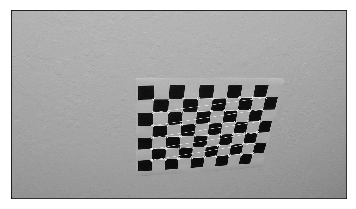

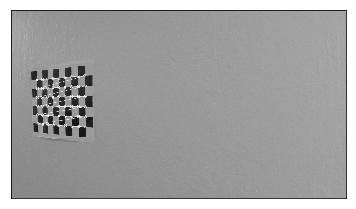

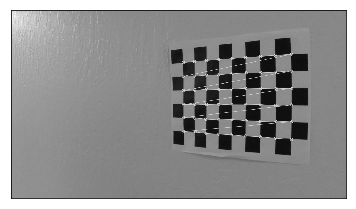

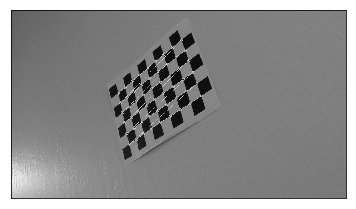

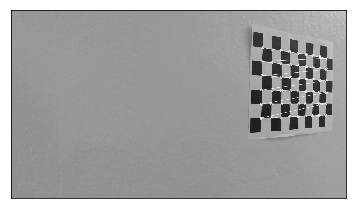

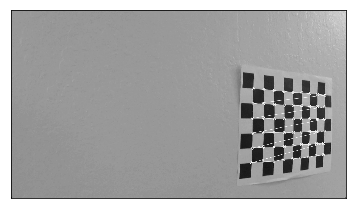

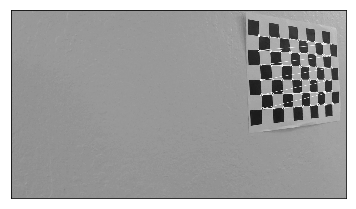

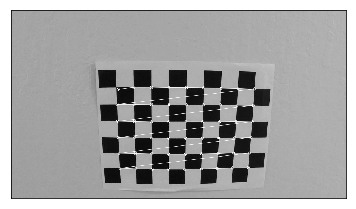

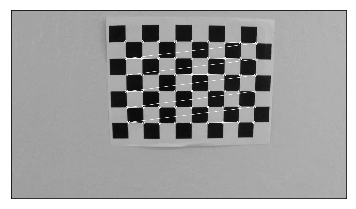

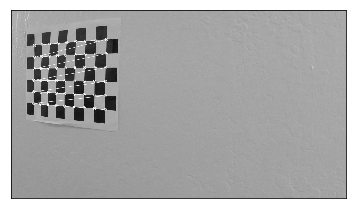

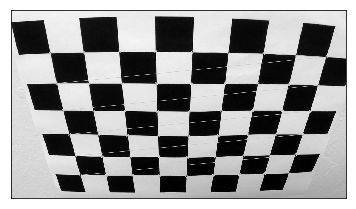

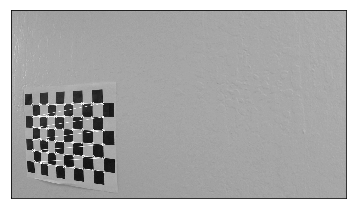

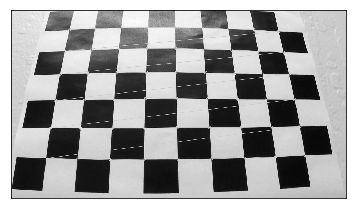

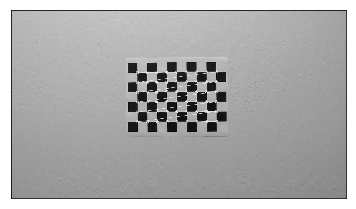

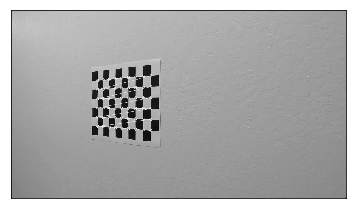

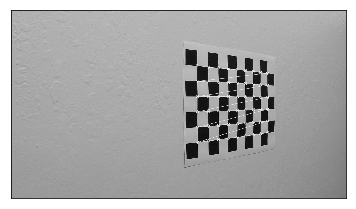

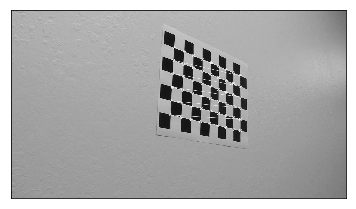

In [17]:
images = glob.glob('./camera_cal/calibration*.jpg')

print('images:\n', images)

#plt.figure(figsize=(20, 100))

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img, (9,6), None)
    
    if ret == True: 
        objpoints.append(objp)
        imgpoints.append(corners)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        fig = plt.imshow(img, cmap = "gray")
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
        cv2.imwrite('./output_images/calibrate{:02d}.jpg'.format(i), img)
        #plt.savefig('./output_images/calibrate{:02d}.jpg'.format(i))
        

## Distortion Correction and Warp

In [18]:
images = glob.glob('./camera_cal/calibration*.jpg')
print('images:\n', images)

images:
 ['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


In [19]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [20]:
def warp(img, offset=100, nx=9, ny=6):
    
    img_size = (img.shape[1], img.shape[0])
    
    ret, corners =  cv2.findChessboardCorners(img, (nx, ny), None)
    
    if ret == True:
        
    
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        M = cv2.getPerspectiveTransform(src, dst)  
        warped = cv2.warpPerspective(img, M, img_size)
  
    else: warped = img
    
    return warped 

images:
 ['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


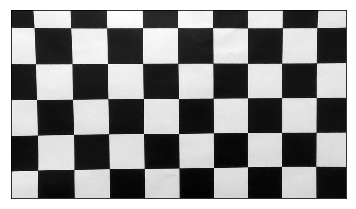

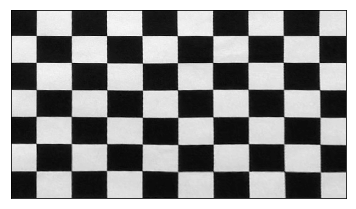

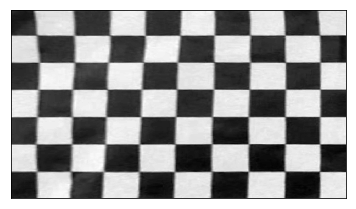

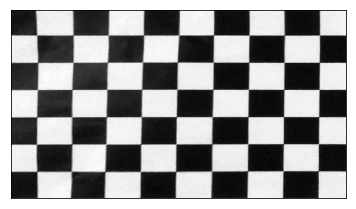

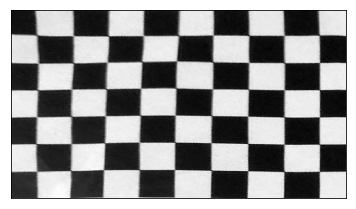

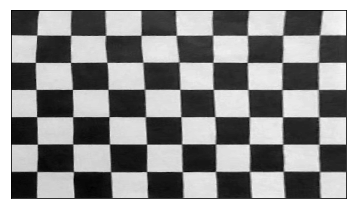

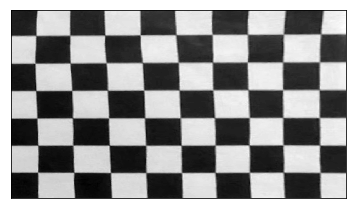

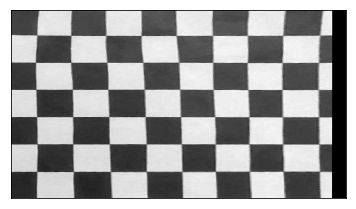

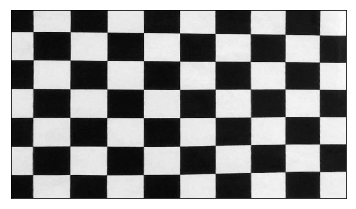

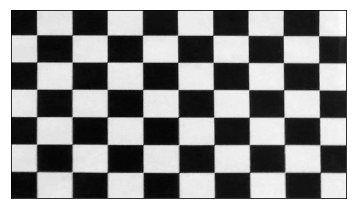

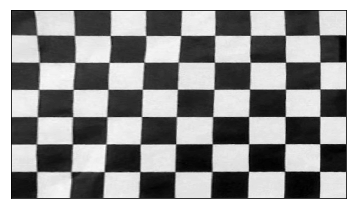

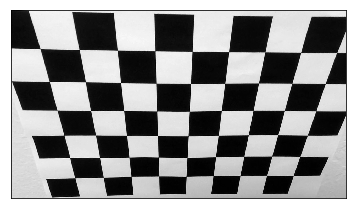

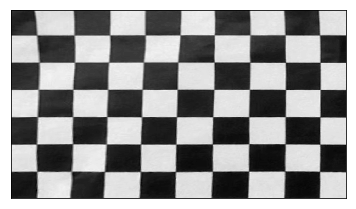

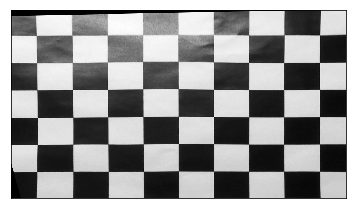

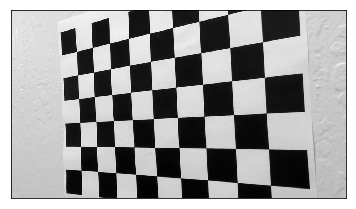

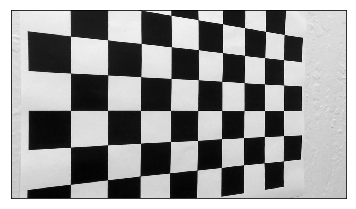

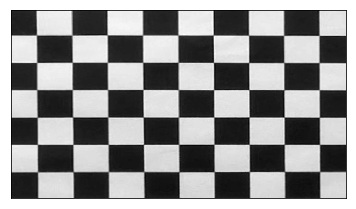

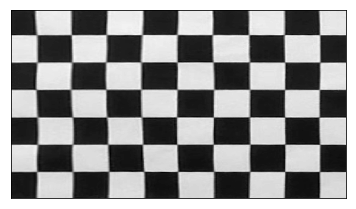

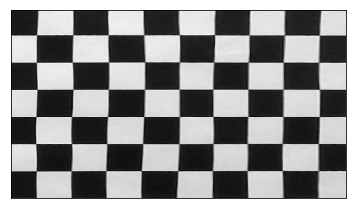

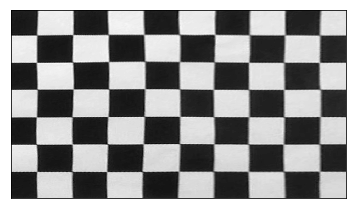

In [21]:
print('images:\n', images)

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = cal_undistort(img, objpoints, imgpoints)
    img = warp(img)
 
    plt.figure()
    fig = plt.imshow(img, cmap = "gray")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    cv2.imwrite('./output_images/warp{:02d}.jpg'.format(i), img)
    #plt.savefig('./output_images/warp{:02d}.jpg'.format(i))

## Create Thresholded Bianary Image 

In [22]:
images = glob.glob('./test_images/*.jpg')
print(images)

['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


In [23]:
def dir_thresh(img, thresh=(0, np.pi/2), kernel_size=3):
    
    abs_sobel = np.zeros_like(img)
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
        
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    #print('absgraddir:', absgraddir)
    
    binary_output = np.zeros_like(absgraddir)
    binary_output = np.int8(binary_output)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    #print('binary output:', binary_output.shape, binary_output)
    
    return binary_output
    

In [24]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=5, thresh=(0,255)):
    
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [25]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
     
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output


images:
 ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']


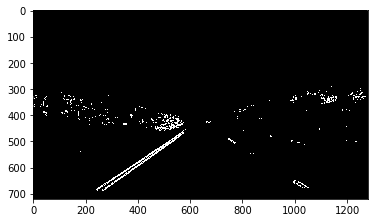

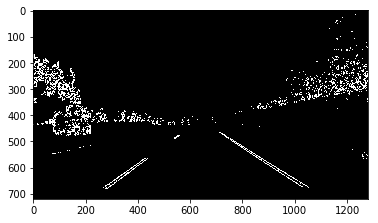

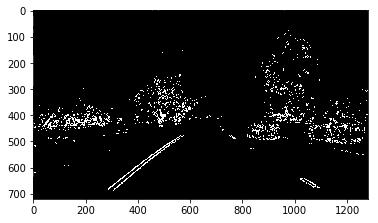

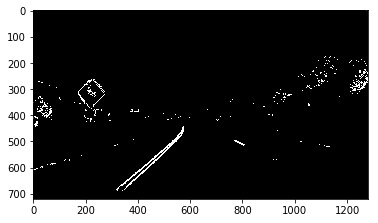

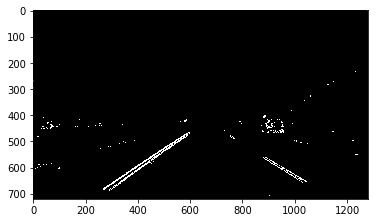

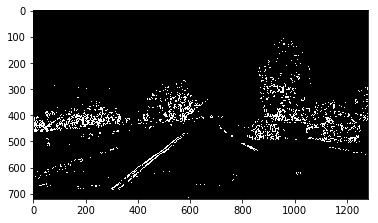

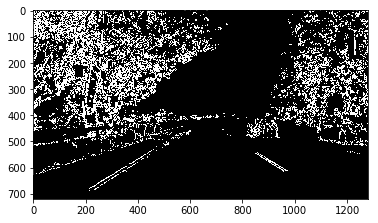

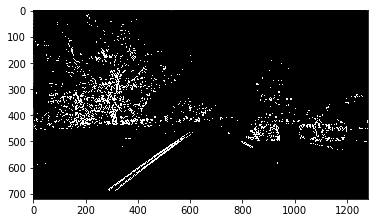

In [44]:
print('images:\n', images)

#plt.figure(figsize=(20, 100))
ksize = 5

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (50, 255)
    binary = np.zeros_like(S)
    #binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    img = S
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_thresh(img, kernel_size=ksize, thresh=(0.2, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    img = combined.copy()
    img = cv2.convertScaleAbs(img, alpha=(255.0))
 
    cv2.imwrite('./output_images/thresh{:02d}.jpg'.format(i), img )
    plt.figure()
    fig = plt.imshow(img, cmap = "gray")
    #fig.axes.get_xaxis().set_visible(False)
    #fig.axes.get_yaxis().set_visible(False)
    
    
    
    #plt.savefig('./output_images/thresh{:02d}.jpg'.format(i))
    

## Perspective Transformation to Have Birds-Eye View

In [45]:
images = glob.glob('./output_images/thresh*.jpg')
print(images)

['./output_images/thresh00.jpg', './output_images/thresh01.jpg', './output_images/thresh02.jpg', './output_images/thresh03.jpg', './output_images/thresh04.jpg', './output_images/thresh05.jpg', './output_images/thresh06.jpg', './output_images/thresh07.jpg']


In [66]:

src = np.float32( 
    [[630, 450],
     [250, 719],
     [650, 450],
     [820, 719]])

dst = np.float32( 
    [[250, 450],
     [250, 719],
     [820, 450],
     [820, 719]])
     

#dst = src
'''
src = np.float32( 
    [[450, 630],
     [719, 250],
     [450, 650],
     [719, 820]])

dst = np.float32( 
    [[450, 250],
     [719, 250],
     [450, 820],
     [719, 820]])
     
'''

'\nsrc = np.float32( \n    [[450, 630],\n     [719, 250],\n     [450, 650],\n     [719, 820]])\n\ndst = np.float32( \n    [[450, 250],\n     [719, 250],\n     [450, 820],\n     [719, 820]])\n     \n'

img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)
img size: (720, 1280)


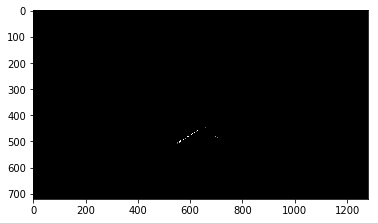

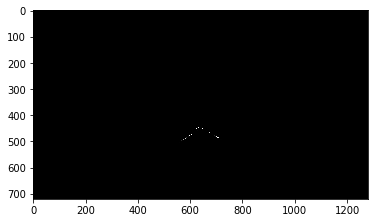

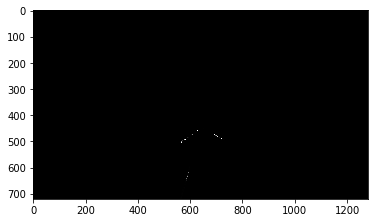

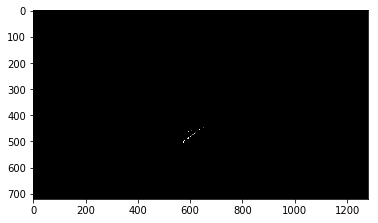

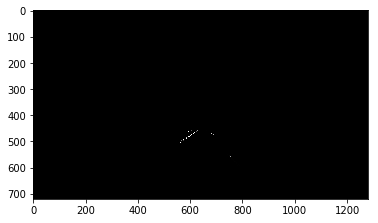

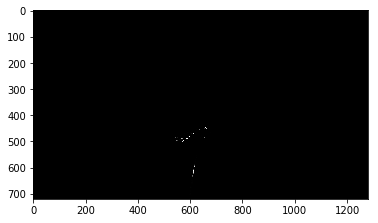

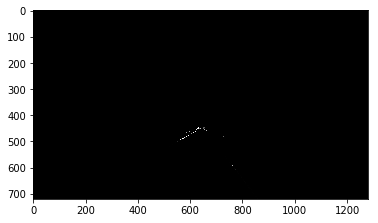

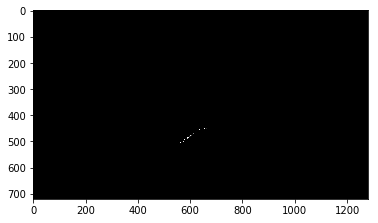

In [74]:
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape
    #img = cal_undistort(img, objpoints, imgpoints)
    #img = warp(img)
 
    print('img size:', img_size)

    M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    
    img = warped
    
    plt.figure()
    plt.imshow(img, cmap = "gray")

## Detect Lane Pixes and Fit to Find the Lane Boundry

## Determine the curvature of the lane and vehicle position with respect to center.

## Warp the detected lane boundaries back onto the original image.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.